# ENAS - Discovered network from macro search space for image classification


**Importing Keras and Python libraries**

In [0]:
import tensorflow as tf
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model ,load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D ,DepthwiseConv2D ,SeparableConv2D 
from keras.layers import Activation, Flatten, Dropout ,Input,GlobalAveragePooling2D ,Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Lambda

from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import keras

**Initialize datasets training and test**

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

**Printing 10 classes for Cifar10 datasets**

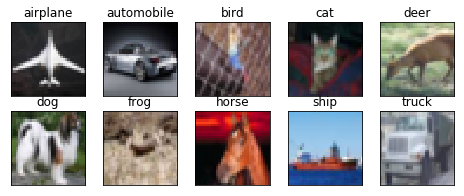

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Define function to show model projectories**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

**Define accuracy function  which predict datsets on trained model**

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

**Scaling down variables (test and train) to have values with in range of 0 to 1**

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

**Define space to depth function - to cancatenate two shapes**

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

# **Define model for Enas architechture** 

**Plan was to add 1x1 after every block - but could not achieved accuracy bump so avoided **
--- paremetres could have been more less - if applied  two 3x3 instead one 5x5 ,But followed the exact diagram :(
--** 

In [0]:
# Define the model as functional API 

input = Input(shape=(32,32,3))

#####################  BLOCK 1########################

# Layer 1 -- using Seperable 5X5- five outputs we have -need to concatenate
x1 = SeparableConv2D(16,5, border_mode ='same',name ='SepConv1')(input)
x1 = BatchNormalization(name='bn1')(x1)
x1=  Activation('relu')(x1)

# Layer 2 -- using Normal 5X5- five outputs we have -need to concatenate
x2 = Convolution2D(32,5,5, border_mode ='same',name ='NormalConv1')(x1)
x2 = BatchNormalization(name='bn2')(x2)
x2=  Activation('relu')(x2)

# Layer 3 -- using Normal 5X5- five outputs we have -need to concatenate
x3 = Convolution2D(64,5,5, border_mode ='same',name ='NormalConv2')(x2)
x3 = BatchNormalization(name='bn3')(x3)
x3=  Activation('relu')(x3)

# x3=  x3 + x1 
concat_1 =Concatenate(name ='cancat1')([x3,x1])

###########################################################################################
# Layer 4 -- using Seperable 5X5- five outputs we have -need to concatenate
x4 = SeparableConv2D(64,5, border_mode ='same',name ='SepConv2')(concat_1)
x4 = BatchNormalization(name='bn4')(x4)
x4=  Activation('relu')(x4)

# x4 = x4+x1

concat_2 =Concatenate(name ='cancat2')([x4,x1]) #doing 1x1 with normal 5x5 to pas info
# concat_2 = Convolution2D(128,1,1, activation='relu',border_mode ='same', name='conv1_4')(concat_2) 

MaxPool1 = MaxPooling2D((2,2), name='pool1')(concat_2)

#####################  BLOCK 2###################################


# Layer 5 -- using Seperable 3x3- five outputs we have -need to concatenate
x5 = SeparableConv2D(32,3,border_mode ='same',name ='SepConv3')(MaxPool1)
x5 = BatchNormalization(name='bn5')(x5)
x5=  Activation('relu')(x5)

#input to layer 6 ->  x1+x4+x5

concat_1_4 =Concatenate(name ='cancat3')([x4,x1])
concat_1_4 = Lambda(space_to_depth_x2)(concat_1_4)

# input to x6 = x1+ x4 + x5

concat_3 =Concatenate(name ='cancat4')([concat_1_4,x5])
###########################################################################################

# Layer 6 -- using Normal 5X5- five outputs we have -need to concatenate
x6 = Convolution2D(64,5,5, border_mode ='same',name ='NormalConv3')(concat_3)
x6 = BatchNormalization(name='bn6')(x6)
x6=  Activation('relu')(x6)


# input to x7 layer x6---x7_input = x5+x6+x3+x4

concat_3_4 =Concatenate(name ='cancat5')([x4,x3])
concat_5_6 =Concatenate(name ='cancat6')([x5,x6])
depth_adjust_concat_3_4 = Lambda(space_to_depth_x2)(concat_3_4)
concat_4 =Concatenate(name ='cancat7')([depth_adjust_concat_3_4,concat_5_6])

###########################################################################################

# Layer 7 -- using Seperable 3x3- five outputs we have -need to concatenate
x7 = SeparableConv2D(64,3, border_mode ='same',name ='SepConv4')(concat_4)
x7 = BatchNormalization(name='bn7')(x7)
x7=  Activation('relu')(x7)

###########################################################################################

# X8 input prepration -->x7+x5+x6+x1+x4+x3
concat_x134 = Concatenate(name ='cancatx')([x4,x1,x3])
concat_x567 =Concatenate(name ='cancaty')([x6,x7,x5])

depth_adjust_concat_x3_x1 = Lambda(space_to_depth_x2)(concat_x134)
x8_input = Concatenate(name ='cancat8_1')([depth_adjust_concat_x3_x1,concat_x567])
########################################################################################### 

# Layer 8 -- using Seperable 5X5- five outputs we have -need to concatenate
x8 = SeparableConv2D(64,5, border_mode ='same',name ='SepConv5')(x8_input)
x8 = BatchNormalization(name='bn8')(x8)
x8=  Activation('relu')(x8)

###########################################################################################
# X(14578)-- input to max pool

concat_578 =Concatenate(name ='can')([x5,x7,x8])
concat_x14 =Concatenate(name ='cancat8_2')([x1,x4])
depth_adjust_concat_x3_x1 = Lambda(space_to_depth_x2)(concat_x14)
maxpool2_input = Concatenate(name ='cancat8_3')([depth_adjust_concat_x3_x1,concat_578])

MaxPool2 = MaxPooling2D((2,2), name='pool2')(maxpool2_input)

# x9 input preaparation

depth_adjust_x6 = Lambda(space_to_depth_x2)(x6)
x9_input = Concatenate(name ='cancat9')([MaxPool2,depth_adjust_x6])


#################################BLOCK 3#########################################

# Layer 9 -- using Normal 5X5- five outputs we have -need to concatenate
x9 = Convolution2D(64,5,5, border_mode ='same',name ='NormalConv4')(x9_input)
x9 = BatchNormalization(name='bn9')(x9)
x9=  Activation('relu')(x9)

###########################################################################################
# x10 input preparation- x1+x2+x9+x7
concat_12 = Concatenate(name ='cancat10')([x1,x2])

depth_adjust_x12 = Lambda(space_to_depth_x2)(concat_12)
concat_x12_x7= Concatenate(name ='cancat11')([depth_adjust_x12,x7])
depth_adjust_concat_x12_x7 = Lambda(space_to_depth_x2)(concat_x12_x7)
x10_input= Concatenate(name ='cancat12')([depth_adjust_concat_x12_x7,x9])


# ADding  1x1 after concat to reduce no of parameters
x10_input= Convolution2D(128,1,1, activation='relu',border_mode ='same', name='conv1_8')(x10_input) 

# Layer 10 -- using Seperable 5x5- five outputs we have -need to concatenate
x10 = SeparableConv2D(128,5,5, border_mode ='same',name ='SepConv6')(x10_input)
x10 = BatchNormalization(name='bn10')(x10)
x10=  Activation('relu')(x10)

###########################################################################################
# x11 input preparation
concat_23 = Concatenate(name ='cancat13')([x3,x2])
depth_adjust_x23 = Lambda(space_to_depth_x2)(concat_23)
concat_x23_x5= Concatenate(name ='cancat14')([depth_adjust_x23,x5])
depth_adjust_concat_x23_x5 = Lambda(space_to_depth_x2)(concat_x23_x5)

x11_input= Concatenate(name ='cancat15')([depth_adjust_concat_x12_x7,x9,x10])

# Adding  1x1 after concat to reduce no of parameters
x11_input= Convolution2D(256,1,1, activation='relu',border_mode ='same', name='conv1_8_1')(x11_input) 

# Layer 11 -- using Normal 3x3- five outputs we have -need to concatenate
x11 = Convolution2D(64,3,3, border_mode ='same',name ='NormalConv5')(x11_input)
x11 = BatchNormalization(name='bn11')(x11)
x11=  Activation('relu')(x11)

###########################################################################################

# x12 input preparation
depth_adjust_concat_x134 = Lambda(space_to_depth_x2)(concat_x134)
concat_x57= Concatenate(name ='cancat17')([x5,x7]) 
concat_x134_x57= Concatenate(name ='cancat18')([concat_x57,depth_adjust_concat_x134]) 
depth_adjust_concat_x134_57 = Lambda(space_to_depth_x2)(concat_x134_x57)
x12_input= Concatenate(name ='cancat19')([depth_adjust_concat_x134_57,x10,x11])  

# Layer 12 -- using Seperable 5x5- five outputs we have -need to concatenate
x12 = SeparableConv2D(64,5, border_mode ='same',name ='SepConv7')(x12_input)
x12 = BatchNormalization(name='bn12')(x12)
x12=  Activation('relu')(x12)


###########################################################################################

# x13 input preparation
concat_x10_12= Concatenate(name ='cancat20')([x10,x12]) 
depth_adjust_concat_x4 = Lambda(space_to_depth_x2)(x4)
concat_adjust_x4_7= Concatenate(name ='cancat21')([depth_adjust_concat_x4,x7]) 
depth_adjust_concat_x4_x10_12 = Lambda(space_to_depth_x2)(concat_adjust_x4_7)
x13_input= Concatenate(name ='cancat22')([depth_adjust_concat_x4_x10_12,concat_x10_12])  


#########################################################################################
#  Output

output1 = Convolution2D(10,1,1, activation='relu',border_mode ='same')(x13_input) 

output = GlobalAveragePooling2D()(output1)
output = Activation('softmax')(output)

model = Model(inputs=[input], outputs=[output])

model.summary()


W0623 18:50:30.719345 140378316568448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 18:50:30.756962 140378316568448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, 5, name="SepConv1", padding="same")`
  import sys
W0623 18:50:30.768120 140378316568448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 18:50:30.817300 140378316568448 deprecation_wrapper.py:119] From /usr/local

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
SepConv1 (SeparableConv2D)      (None, 32, 32, 16)   139         input_1[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 16)   64          SepConv1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           bn1[0][0]                        
__________________________________________________________________________________________________
NormalConv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:194: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu", padding="same")`


In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler ,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/EVA_Phase1/BestModel_7B.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])
epochs = 100
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


W0623 18:50:41.883510 140378316568448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  
W0623 18:51:05.343822 140378316568448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a f

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 64s 164ms/step - loss: 1.7389 - acc: 0.4114 - val_loss: 1.7876 - val_acc: 0.4015
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 59s 151ms/step - loss: 1.3776 - acc: 0.5335 - val_loss: 1.6111 - val_acc: 0.4728
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 59s 151ms/step - loss: 1.2160 - acc: 0.5928 - val_loss: 1.6219 - val_acc: 0.4822
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 60s 153ms/step - loss: 1.1202 - acc: 0.6286 - val_loss: 1.2477 - val_acc: 0.5930
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 60s 154ms/step - loss: 1.0444 - a

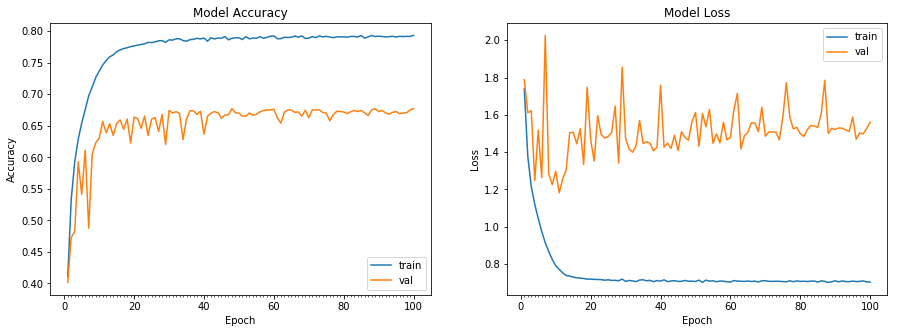

Accuracy on test data is: 67.72


In [0]:
start = time.time()
batch_size = 128
# Train the model
model_info = model.fit_generator(
        datagen.flow(train_features, train_labels, batch_size =batch_size , shuffle=True),
       samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
        validation_data = (test_features, test_labels), verbose=1,
        callbacks=[checkpoint,LearningRateScheduler(scheduler, verbose=1)])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))